In [79]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

In [124]:
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [81]:
def riqi_2_year_month(df, col='日期'):
    '''
    get year month & day
    '''
    # df[col] = pd.to_datetime(df[col])
    # df['年'] = df[col].dt.year
    # df['月'] = df[col].dt.month
    # df['日'] = df[col].dt.day
    return df



def fill_missing_dates(df, date_col='日期'):
    """
    Ensure that the dates in the DataFrame are continuous by adding missing dates.
    Missing values are filled using the last observed non-missing value.
    The input DataFrame's structure is preserved (no index changes).

    Parameters:
    - df: pandas DataFrame containing the data.
    - date_col: str, the name of the date column (default is '日期').

    Returns:
    - pandas DataFrame with continuous dates and filled missing values.
    """
    
    # Convert the date column to datetime
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Create a date range from the minimum to the maximum date in the DataFrame
    date_range = pd.date_range(start=df[date_col].min(), end=df[date_col].max(), freq='D')
    
    # Create a new DataFrame with the full date range
    full_df = pd.DataFrame({date_col: date_range})
    
    # Merge the original DataFrame with the full date range DataFrame
    merged_df = pd.merge(full_df, df, on=date_col, how='left')
    
    # Forward fill the missing values
    merged_df.ffill(inplace=True)
    
    return merged_df


import pandas as pd

def keep_average_if_identical(df):
    """
    If the "最高", "最低", and "平均" columns in the DataFrame are identical,
    keep only the "平均" column.

    Parameters:
    - df: pandas DataFrame containing the data.

    Returns:
    - pandas DataFrame with only the "平均" column if the three columns are identical,
      otherwise returns the original DataFrame.
    """
    
    # Check if the "最高", "最低", and "平均" columns are identical
    if all(df['最高'] == df['最低']) and all(df['最低'] == df['平均']):
        # Drop the "最高" and "最低" columns
        df = df.drop(columns=['最高', '最低'])
    
    return df



import pandas as pd

def add_previous_days_features(df1, df2, prefix='prefix', shift_days=3, include_0 = True):
    """
    For each row in df1, add the "最高", "最低", and "平均" values from df2 for the previous 7 days.
    The new columns will be named in the format prefix_day_xx, where xx is the number of days before the current date.
    If some of the columns ("最高", "最低", "平均") are missing in df2, only the available columns are processed.

    Parameters:
    - df1: pandas DataFrame containing the main data.
    - df2: pandas DataFrame containing the features to be added.
    - prefix: str, the prefix for the new column names (default is 'prefix').
    - shift_days: int, the number of previous days to consider (default is 7).

    Returns:
    - pandas DataFrame with the new columns added.
    """
    
    # Ensure the "日期" column is in datetime format
    df1['日期'] = pd.to_datetime(df1['日期'])
    df2['日期'] = pd.to_datetime(df2['日期'])
    
    # Create a copy of df1 to avoid modifying the original DataFrame
    result_df = df1.copy()
    
    # Check which columns are available in df2
    available_columns = [col for col in ['最高', '最低', '平均'] if col in df2.columns]
    
    # Iterate over the previous shift_days days
    if include_0:
        start = 0 
    else:
        start = 1

    for i in range(start, shift_days+1):
        # Shift df2 by i days to get the previous days' data
        shifted_df = df2[available_columns].shift(i)
        shifted_df['日期'] = df2['日期']
        
        # Merge the shifted data with df1 on the "日期" column
        merged_df = pd.merge(result_df, shifted_df, on='日期', how='left', suffixes=('', f'_{i}'))
        
        # Rename the columns to the desired format
        for col in available_columns:
            merged_df.rename(columns={f'{col}_{i}': f'{prefix}_{i}_{col}'}, inplace=True)
        
        # Update the result_df with the new columns
        result_df = merged_df
    
    return result_df

In [82]:
df = pd.read_excel('./PPData/1-华东市场PP粒市场价_法定工作日.xlsx')
df = df.loc[:,['日期','最低','最高','平均','同比','环比']]
# df = fill_missing_dates(df)
df = keep_average_if_identical(df)
df1 = riqi_2_year_month(df=df, col='日期')
df1

,日期,最低,最高,平均,同比,环比
0,2014-12-01,10200.0,10300.0,10250.0,NaN,NaN
1,2014-12-02,10150.0,10250.0,10200.0,NaN,-0.49%
2,2014-12-03,10050.0,10150.0,10100.0,NaN,-0.98%
3,2014-12-04,9900.0,10000.0,9950.0,NaN,-1.49%
4,2014-12-05,9750.0,9850.0,9800.0,NaN,-1.51%
...,...,...,...,...,...,...
1644,2021-07-09,8450.0,8600.0,8525.0,7.57%,0.18%
1645,2021-07-12,8600.0,8700.0,8650.0,9.84%,1.47%
1646,2021-07-13,8520.0,8700.0,8610.0,9.33%,-0.46%
1647,2021-07-14,8450.0,8600.0,8525.0,8.74%,-0.99%


In [83]:
df = pd.read_excel('./PPData/2-中国PP月度产量.xlsx')
df = df.loc[:,['日期','最低','最高','平均','同比','环比']]
df = fill_missing_dates(df)
df = keep_average_if_identical(df)
df2 = riqi_2_year_month(df=df, col='日期')
df2.head()

,日期,平均,同比,环比
0,2014-01-31,1138.6,NaN,NaN
1,2014-02-01,1138.6,NaN,NaN
2,2014-02-02,1138.6,NaN,NaN
3,2014-02-03,1138.6,NaN,NaN
4,2014-02-04,1138.6,NaN,NaN


In [84]:
df = pd.read_excel('./PPData/3-塑编行业周度开工率.xlsx')
df = df.loc[:,['日期','最低','最高','平均','同比','环比']]
df = fill_missing_dates(df)
df = keep_average_if_identical(df)
df3 = riqi_2_year_month(df=df, col='日期')
df3.head()

,日期,平均,同比,环比
0,2011-01-07,75.0,NaN,NaN
1,2011-01-08,75.0,NaN,NaN
2,2011-01-09,75.0,NaN,NaN
3,2011-01-10,75.0,NaN,NaN
4,2011-01-11,75.0,NaN,NaN


In [85]:
df = pd.read_excel('./PPData/4-PP拉丝级生产比例日度数据.xlsx')
print(df.columns)
df = df.loc[:,['日期','最低','最高','平均','同比','环比']]
df = fill_missing_dates(df)
df = keep_average_if_identical(df)
df4 = riqi_2_year_month(df=df, col='日期')
df4.head()

Index(['DIID', '数据项名称', '产品名称', '企业名称', '区域名称', '市场名称', '更新周期', '规格型号', '数据类型',
       '单位', '日期', '最低', '最高', '平均', '同比', '环比', '备注'],
      dtype='object')


,日期,平均,同比,环比
0,2014-01-02,35.51,NaN,NaN
1,2014-01-03,37.08,NaN,4.42%
2,2014-01-04,37.08,NaN,4.42%
3,2014-01-05,37.08,NaN,4.42%
4,2014-01-06,38.41,NaN,3.59%


In [86]:
df = pd.read_excel('./PPData/5-PP进口量月度数据_滞后一月更新.xlsx')
print(df.columns)
df = df.loc[:,['日期','最低','最高','平均','同比','环比']]
df = fill_missing_dates(df)
df = keep_average_if_identical(df)
df5 = riqi_2_year_month(df=df, col='日期')
df5.head()

Index(['DIID', '数据项名称', '产品名称', '企业名称', '区域名称', '市场名称', '更新周期', '规格型号', '数据类型',
       '单位', '日期', '最低', '最高', '平均', '同比', '环比', '备注'],
      dtype='object')


,日期,平均,同比,环比
0,2010-01-31,337.52,44.40%,-9.67%
1,2010-02-01,337.52,44.40%,-9.67%
2,2010-02-02,337.52,44.40%,-9.67%
3,2010-02-03,337.52,44.40%,-9.67%
4,2010-02-04,337.52,44.40%,-9.67%


In [87]:
df = pd.read_excel('./PPData/6-PP注塑制品周度开工率.xlsx')
print(df.columns)
df = df.loc[:,['日期','最低','最高','平均','同比','环比']]
df = fill_missing_dates(df)
df = keep_average_if_identical(df)
df6 = riqi_2_year_month(df=df, col='日期')
df6.head()

Index(['DIID', '数据项名称', '产品名称', '企业名称', '区域名称', '市场名称', '更新周期', '规格型号', '数据类型',
       '单位', '日期', '最低', '最高', '平均', '同比', '环比', '备注'],
      dtype='object')


,日期,平均,同比,环比
0,2014-01-03,62.0,NaN,NaN
1,2014-01-04,62.0,NaN,NaN
2,2014-01-05,62.0,NaN,NaN
3,2014-01-06,62.0,NaN,NaN
4,2014-01-07,62.0,NaN,NaN


In [88]:
df = pd.read_excel('./PPData/7-BOPP月度开工率.xlsx')
print(df.columns)
df = df.loc[:,['日期','最低','最高','平均','同比','环比']]
df = fill_missing_dates(df)
df = keep_average_if_identical(df)
df7 = riqi_2_year_month(df=df, col='日期')
df7.head()

Index(['DIID', '数据项名称', '产品名称', '企业名称', '区域名称', '市场名称', '更新周期', '规格型号', '数据类型',
       '单位', '日期', '年', '月', '最低', '最高', '平均', '同比', '环比', '备注'],
      dtype='object')


,日期,平均,同比,环比
0,2010-01-01,87.31,NaN,NaN
1,2010-01-02,87.31,NaN,NaN
2,2010-01-03,87.31,NaN,NaN
3,2010-01-04,87.31,NaN,NaN
4,2010-01-05,87.31,NaN,NaN


In [89]:
df = pd.read_excel('./PPData/8-PDH生产路线日度含税成本.xlsx')
print(df.columns)
df = df.loc[:,['日期','最低','最高','平均','同比','环比']]
df = fill_missing_dates(df)
df = keep_average_if_identical(df)
df8 = riqi_2_year_month(df=df, col='日期')
df8.head()

Index(['DIID', '数据项名称', '产品名称', '企业名称', '区域名称', '市场名称', '更新周期', '规格型号', '数据类型',
       '单位', '日期', '最低', '最高', '平均', '同比', '环比', '备注'],
      dtype='object')


,日期,平均,同比,环比
0,2019-02-13,6771.99,NaN,NaN
1,2019-02-14,6926.38,NaN,2.28%
2,2019-02-15,6824.66,NaN,-1.47%
3,2019-02-16,6824.66,NaN,-1.47%
4,2019-02-17,6824.66,NaN,-1.47%


In [90]:
df = pd.read_excel('./PPData/9-乙烯裂解生产路线日度含税成本.xlsx')
print(df.columns)
df = df.loc[:,['日期','最低','最高','平均','同比','环比']]
df = fill_missing_dates(df)
df = keep_average_if_identical(df)
df9 = riqi_2_year_month(df=df, col='日期')
df9.head()

Index(['DIID', '数据项名称', '产品名称', '企业名称', '区域名称', '市场名称', '更新周期', '规格型号', '数据类型',
       '单位', '日期', '最低', '最高', '平均', '同比', '环比', '备注'],
      dtype='object')


,日期,平均,同比,环比
0,2014-12-31,6051.84,NaN,NaN
1,2015-01-01,6051.84,NaN,NaN
2,2015-01-02,6051.84,NaN,NaN
3,2015-01-03,6051.84,NaN,NaN
4,2015-01-04,5987.64,NaN,-1.06%


In [91]:
df = pd.read_excel('./PPData/10-MTO生产路线日度含税成本.xlsx')
print(df.columns)
df = df.loc[:,['日期','最低','最高','平均','同比','环比']]
df = fill_missing_dates(df)
df = keep_average_if_identical(df)
df10 = riqi_2_year_month(df=df, col='日期')
df10.head()

Index(['DIID', '数据项名称', '产品名称', '企业名称', '区域名称', '市场名称', '更新周期', '规格型号', '数据类型',
       '单位', '日期', '最低', '最高', '平均', '同比', '环比', '备注'],
      dtype='object')


,日期,平均,同比,环比
0,2016-01-04,5500.0,NaN,NaN
1,2016-01-05,5560.0,NaN,1.09%
2,2016-01-06,5560.0,NaN,0.00%
3,2016-01-07,5560.0,NaN,0.00%
4,2016-01-08,5590.0,NaN,0.54%


In [92]:
df = pd.read_excel('./PPData/11-CTO生产路线日度含税成本.xlsx')
print(df.columns)
df = df.loc[:,['日期','最低','最高','平均','同比','环比']]
df = fill_missing_dates(df)
df = keep_average_if_identical(df)
df11 = riqi_2_year_month(df=df, col='日期')
df11.head()

Index(['DIID', '数据项名称', '产品名称', '企业名称', '区域名称', '市场名称', '更新周期', '规格型号', '数据类型',
       '单位', '日期', '最低', '最高', '平均', '同比', '环比', '备注'],
      dtype='object')


,日期,平均,同比,环比
0,2015-01-04,4810.75,NaN,NaN
1,2015-01-05,4810.75,NaN,0.00%
2,2015-01-06,4810.75,NaN,0.00%
3,2015-01-07,4810.75,NaN,0.00%
4,2015-01-08,4810.75,NaN,0.00%


In [93]:
df = pd.read_excel('./PPData/12-外采丙烯生产路线日度含税成本.xlsx')
print(df.columns)
df = df.loc[:,['日期','最低','最高','平均','同比','环比']]
df = fill_missing_dates(df)
df = keep_average_if_identical(df)
df12 = riqi_2_year_month(df=df, col='日期')
df12.head()

Index(['DIID', '数据项名称', '产品名称', '企业名称', '区域名称', '市场名称', '更新周期', '规格型号', '数据类型',
       '单位', '日期', '最低', '最高', '平均', '同比', '环比', '备注'],
      dtype='object')


,日期,平均,同比,环比
0,2011-01-04,11253.5,NaN,NaN
1,2011-01-05,11253.5,NaN,0.00%
2,2011-01-06,11253.5,NaN,0.00%
3,2011-01-07,11253.5,NaN,0.00%
4,2011-01-08,11253.5,NaN,0.00%


In [94]:
df = pd.read_excel('./PPData/13-大商所PP期货价格_短数据.xlsx')
print(df.columns)
df = df.loc[:,['日期','最低','最高','平均','同比','环比']]
df = fill_missing_dates(df)
df = keep_average_if_identical(df)
df13 = riqi_2_year_month(df=df, col='日期')
df13.head()

Index(['DIID', '数据项名称', '产品名称', '企业名称', '区域名称', '市场名称', '更新周期', '规格型号', '数据类型',
       '单位', '日期', '最低', '最高', '平均', '同比', '环比', '备注'],
      dtype='object')


,日期,平均,同比,环比
0,2019-10-28,8028.0,NaN,NaN
1,2019-10-29,7973.0,NaN,-0.69%
2,2019-10-30,7975.0,NaN,0.03%
3,2019-10-31,7944.0,NaN,-0.39%
4,2019-11-01,7965.0,NaN,0.26%


In [95]:
df = pd.read_excel('./PPData/14-PP月度检修实际损失量.xlsx')
print(df.columns)
df = df.loc[:,['日期','最低','最高','平均','同比','环比']]
df = fill_missing_dates(df)
df = keep_average_if_identical(df)
df14 = riqi_2_year_month(df=df, col='日期')
df14.head()

Index(['DIID', '数据项名称', '产品名称', '企业名称', '区域名称', '市场名称', '更新周期', '规格型号', '数据类型',
       '单位', '日期', '最低', '最高', '平均', '同比', '环比', '备注'],
      dtype='object')


,日期,平均,同比,环比
0,2018-01-31,180.0,NaN,NaN
1,2018-02-01,180.0,NaN,NaN
2,2018-02-02,180.0,NaN,NaN
3,2018-02-03,180.0,NaN,NaN
4,2018-02-04,180.0,NaN,NaN


In [96]:
df = pd.read_excel('./PPData/15-pp石化库存_每3个工作日更新.xlsx')
df = fill_missing_dates(df, date_col='date')
df15 = riqi_2_year_month(df=df, col='date')
df15.rename(columns={'date':'日期', 'inventory':'平均'},inplace=True)
df15.head()

,日期,平均
0,2011-01-16,53.8
1,2011-01-17,53.8
2,2011-01-18,53.8
3,2011-01-19,55.7
4,2011-01-20,55.7


# 特征偏移

In [97]:
df_merge = df1.copy()

df_list = [df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15]

# 特征偏移
i = 2
for df in df_list:
    df_merge = add_previous_days_features(df_merge, df, prefix=f'df{i}', shift_days=3)
    i += 1

# 价格偏移
df_merge = add_previous_days_features(df_merge, df1.loc[:,['日期','平均']], prefix='df1', shift_days=0, include_0=False)

<Axes: >

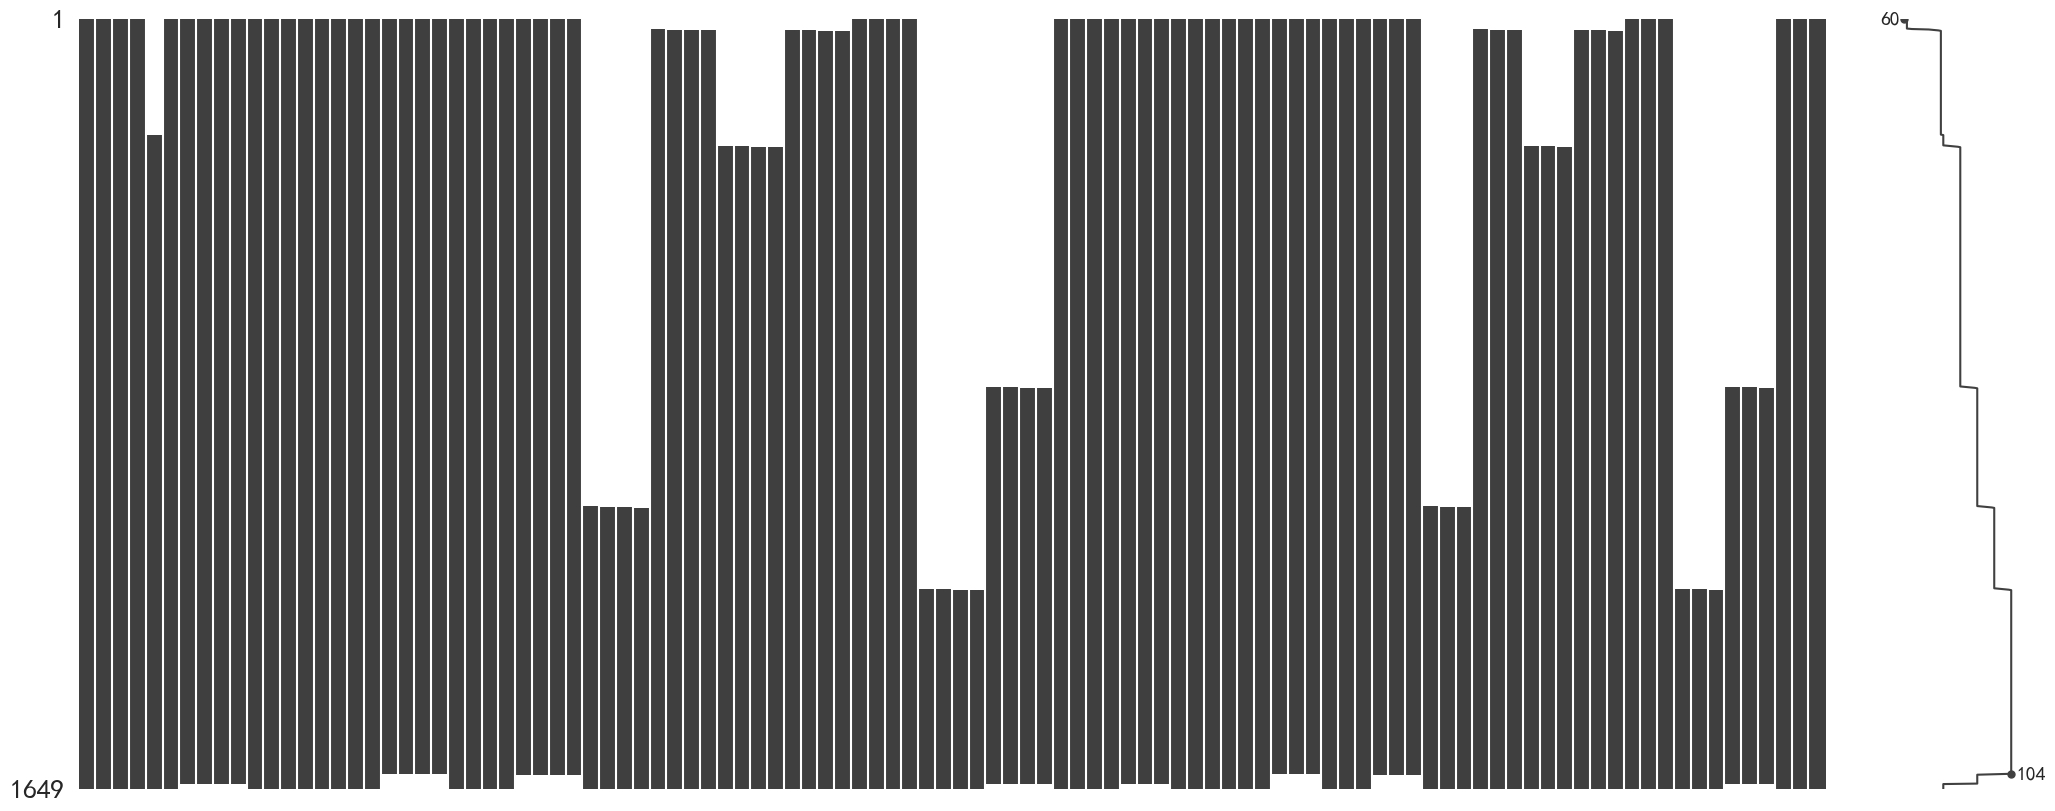

In [98]:
def cal_diff_1(df):
    df = df.copy()
    df['平均'] = df['平均'].diff().fillna(0)
    return df 

diff_1_list = [cal_diff_1(df.loc[:,['日期','平均']]) for df in df_list]

i = 2 
for df in diff_1_list:
    df_merge = add_previous_days_features(df_merge, df, prefix=f'diff_1_df{i}', shift_days=2)
    i += 1
msno.matrix(df_merge)

<Axes: >

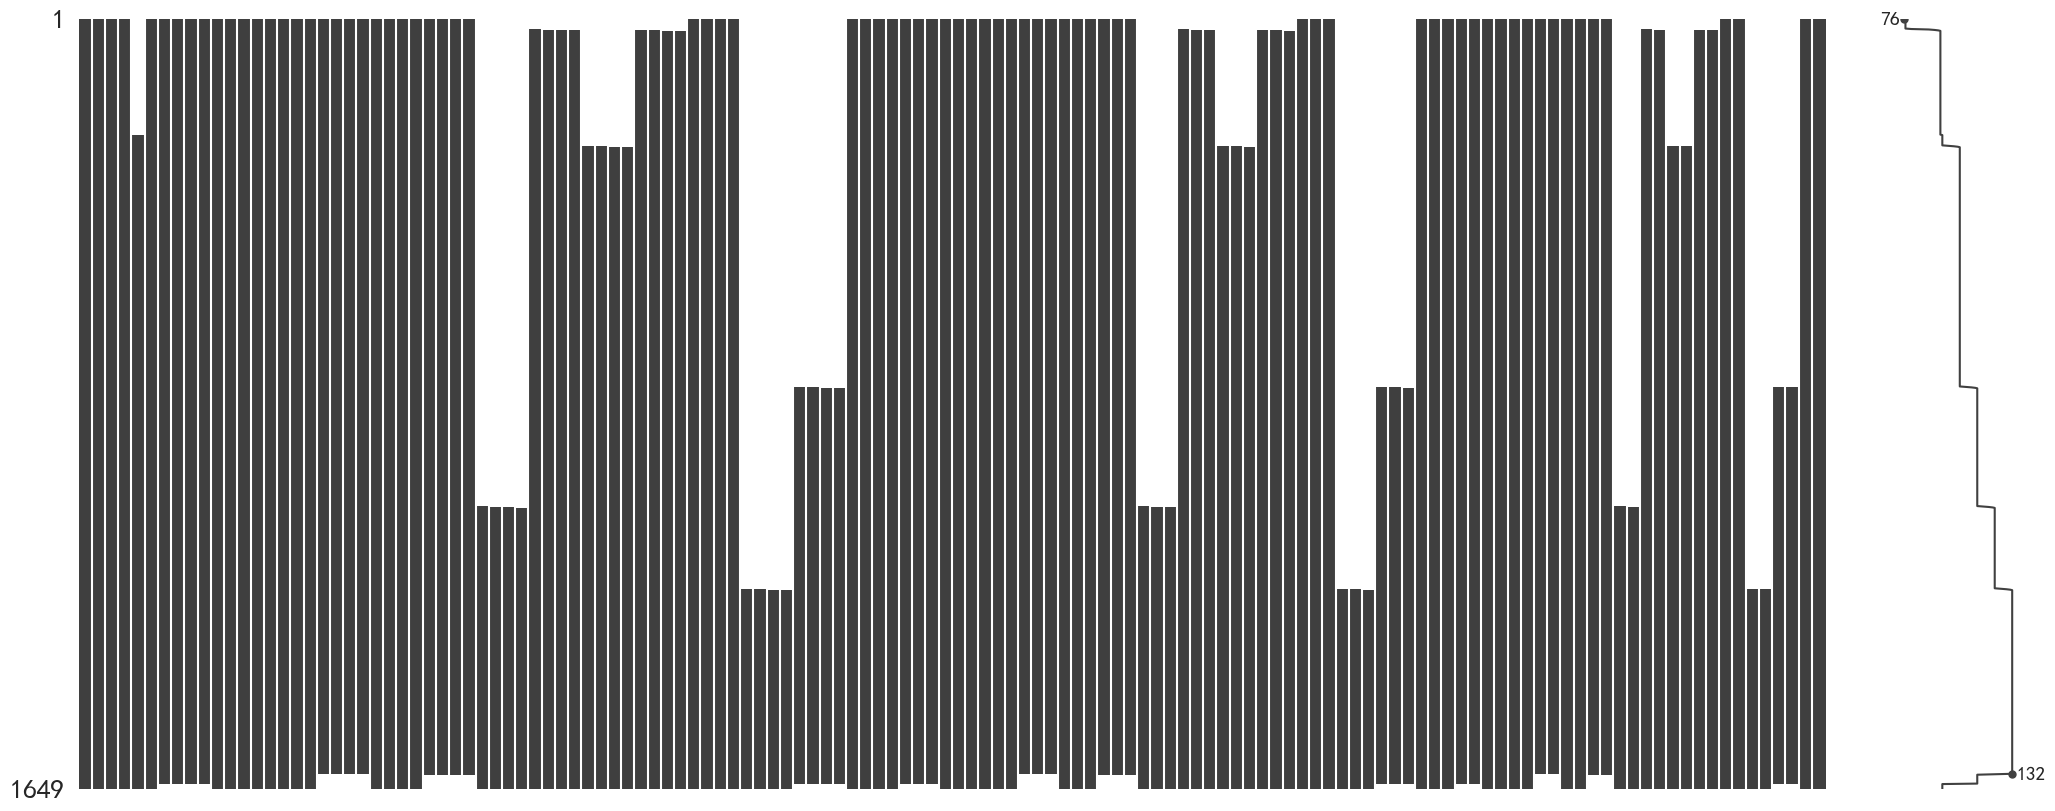

In [99]:
def cal_diff_2(df):
    df = df.copy()
    df['平均'] = df['平均'].diff().diff().fillna(0)
    return df 

diff_2_list = [cal_diff_2(df.loc[:,['日期','平均']]) for df in df_list]

i = 2 
for df in diff_2_list:
    df_merge = add_previous_days_features(df_merge, df, prefix=f'diff_2_df{i}', shift_days=1)
    i += 1

msno.matrix(df_merge)

C:\Users\simonpan\AppData\Local\Temp\ipykernel_16608\1920747479.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned = df_cleaned.query('日期 < "2021-06-01"').fillna(method='ffill').fillna(method='bfill')


<Axes: >

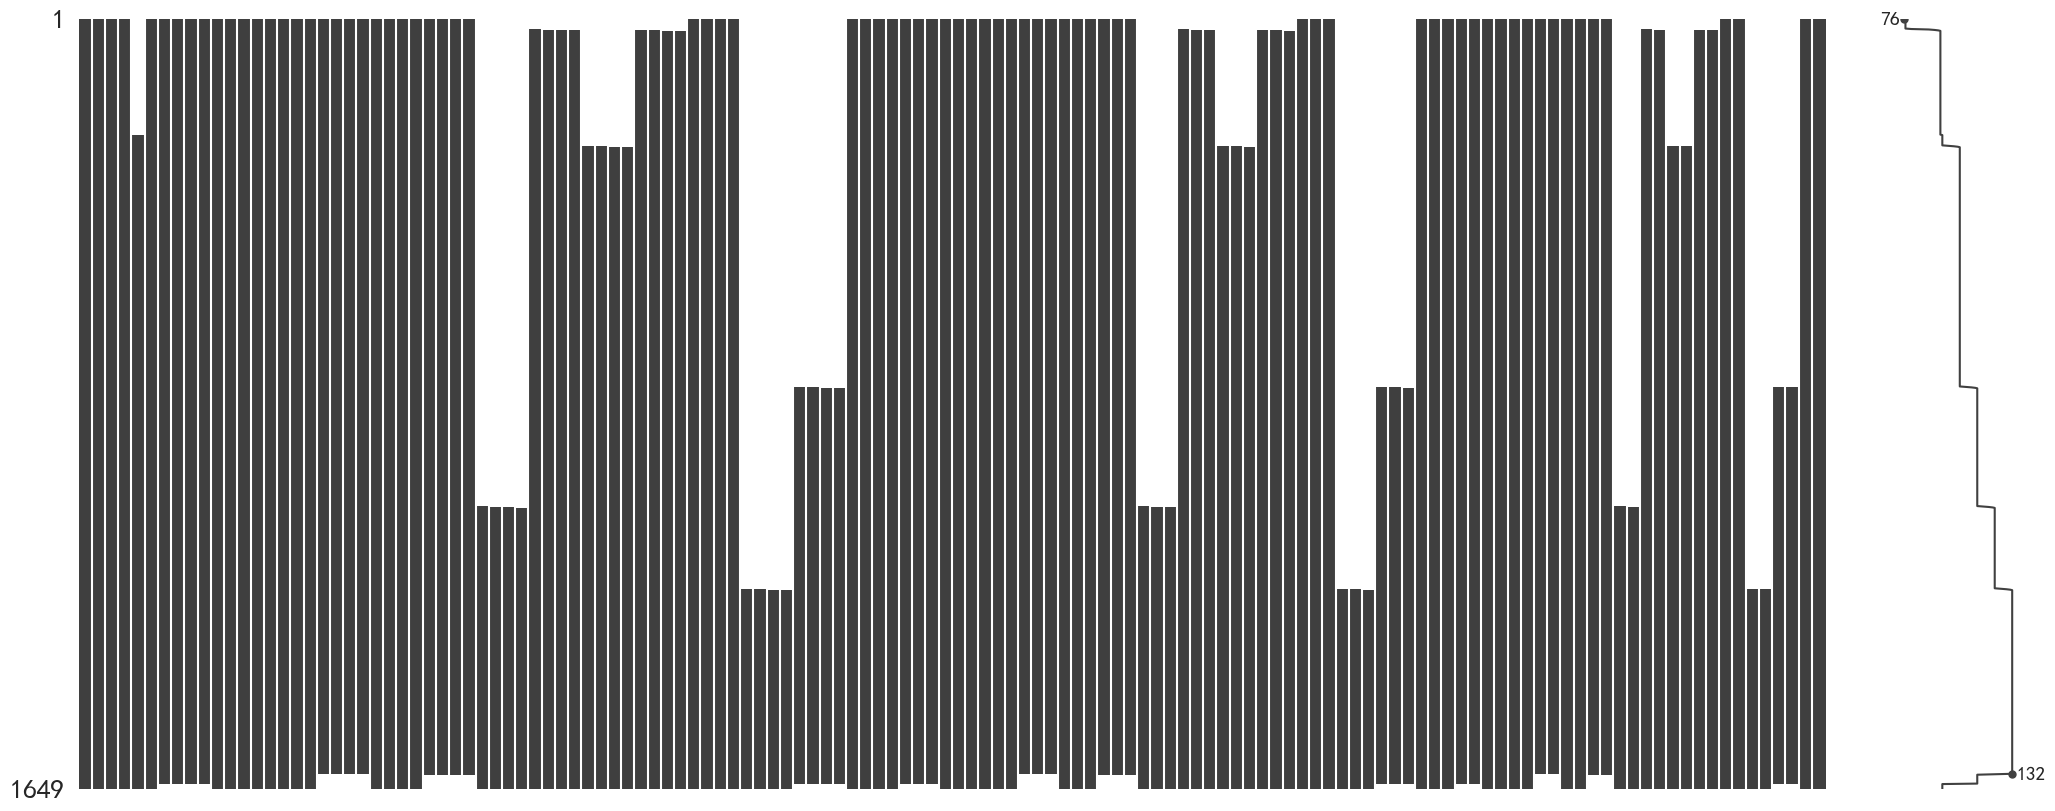

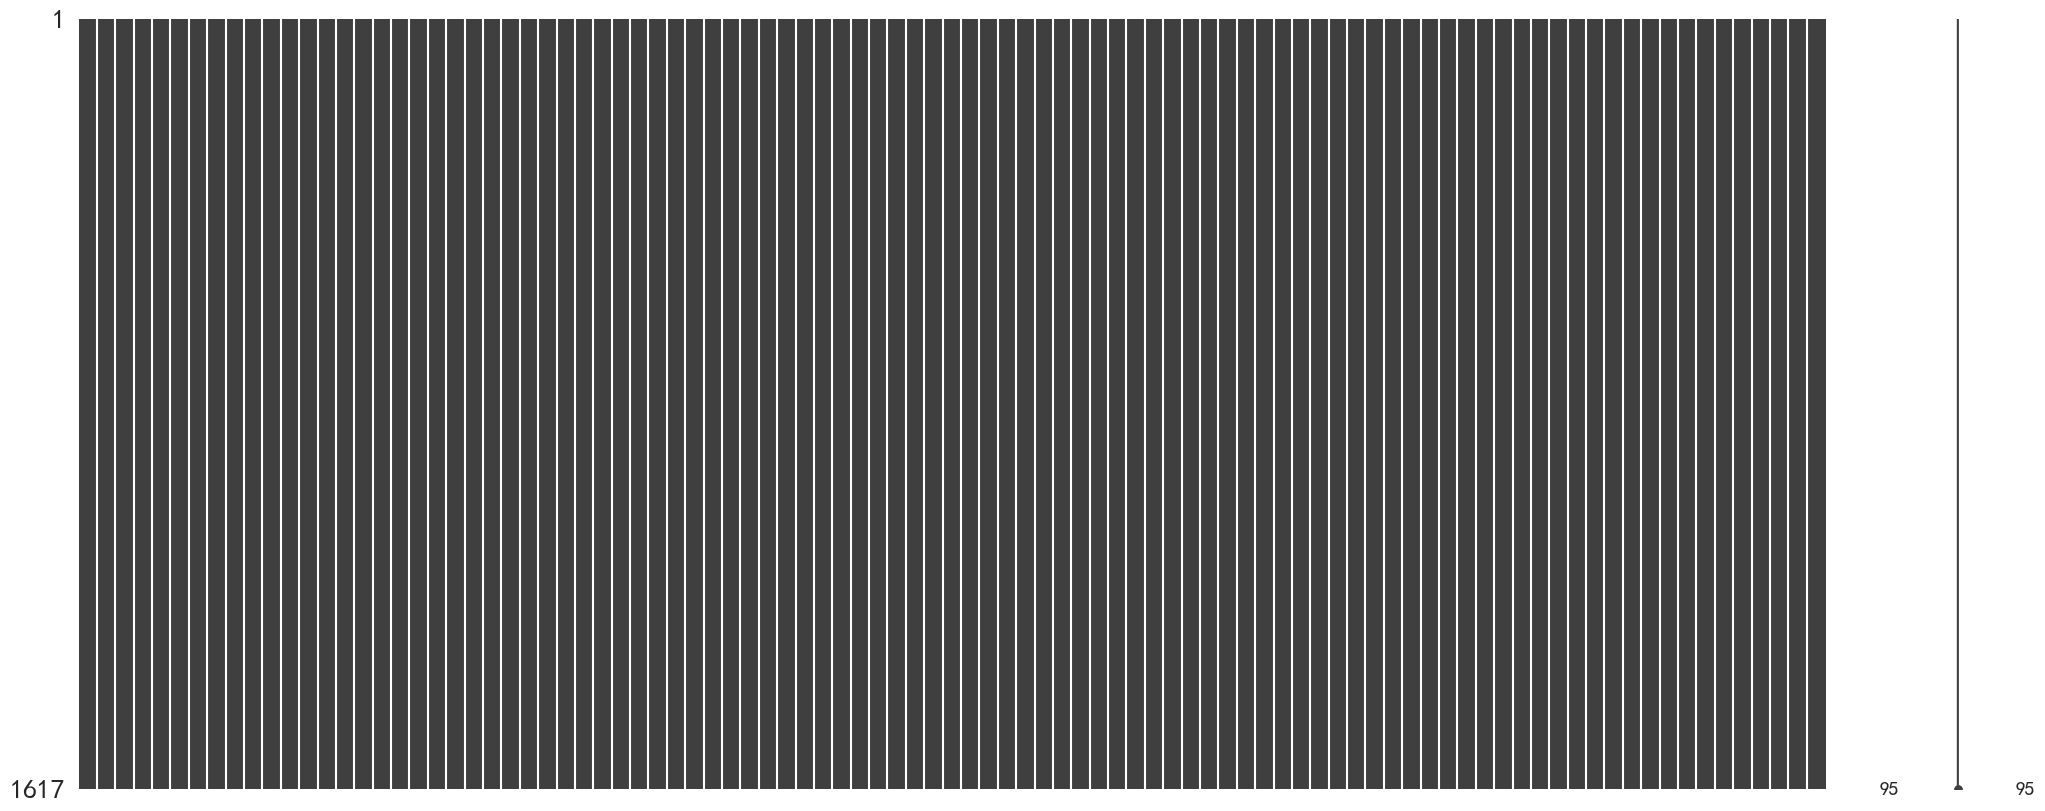

In [100]:
import missingno as msno
# 假设 df 是你的 DataFrame
# threshold 是你指定的阈值，例如 0.5 表示 50%
msno.matrix(df_merge)
# 计算每列的缺失值比例
threshold = 0.1
missing_ratio = df_merge.isnull().mean()

# 选择缺失比例小于等于阈值的列
df_cleaned = df_merge.loc[:, missing_ratio <= threshold]

# df_cleaned 就是删除缺失比例大于阈值的列后的 DataFrame

# 选择2021-07-01之前的数据
df_cleaned = df_cleaned.query('日期 < "2021-06-01"').fillna(method='ffill').fillna(method='bfill')

msno.matrix(df_cleaned)

In [101]:
import pandas as pd

df_cleaned['日期'] = pd.to_datetime(df_cleaned['日期'])

df_cleaned.set_index('日期', inplace=True)

# 分割 DataFrame
train_df = df_cleaned[df_cleaned.index < '2021-01-01']
test_df = df_cleaned[df_cleaned.index >= '2021-01-01']

def split_data(df):
    X = df.iloc[:,4:]
    y = df['平均']
    return X,y 



X_train, y_train = split_data(train_df)
# X_train = X_train.to_numpy()
# y_train = y_train.to_numpy()

X_test, y_test = split_data(test_df)
# X_test = X_test.to_numpy()
# y_test = y_test.to_numpy()

In [102]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import seaborn as sns
import matplotlib.pyplot as plt

# 设置 seaborn 风格
sns.set_theme(style="whitegrid", palette="pastel")

# 假设输入为 X_train, y_train, X_test, y_test
# 1. 训练模型
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(alpha=0.5),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor()
}

# 存储误差结果
results = []

# 存储每天的误差
daily_errors = {}

# 存储每天的预测值和真实值
daily_predictions = {}

# 训练并评估每个模型
for model_name, model in models.items():
    # 训练模型
    model.fit(X_train, y_train)
    
    # 在测试集上预测
    y_pred = model.predict(X_test)
    
    # 计算绝对误差和相对误差
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    # 存储结果
    results.append({
        "Model": model_name,
        "MAE": mae,
        "MAPE": mape
    })
    
    # 计算每天的 MAE 和 MAPE
    daily_mae = np.abs(y_test - y_pred)
    daily_mape = np.abs((y_test - y_pred) / y_test) * 100
    
    # 存储每天的误差
    daily_errors[model_name] = {
        "Daily MAE": daily_mae,
        "Daily MAPE": daily_mape
    }
    
    # 存储每天的预测值和真实值
    daily_predictions[model_name] = {
        "y_test": y_test,
        "y_pred": y_pred
    }

# 将结果转换为 DataFrame
results_df = pd.DataFrame(results)

c:\Users\simonpan\anaconda3\envs\py310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.583e+07, tolerance: 1.323e+05
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8671
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 84
[LightGBM] [Info] Start training from score 8384.693272


In [103]:
def calculate_monthly_metrics(daily_predictions):
    # 创建一个空的 DataFrame 来存储结果
    monthly_metrics_results = []

    # 遍历每个模型
    for model_name, predictions in daily_predictions.items():
        y_test = predictions['y_test']
        y_pred = predictions['y_pred']

        # 将 y_test 和 y_pred 转换为 DataFrame，方便按月份分组
        df = pd.DataFrame({
            'y_test': y_test,
            'y_pred': y_pred,
            'date': y_test.index  # 假设 y_test 的 index 是日期
        })

        # 按月份分组
        df['month'] = df['date'].dt.month

        # 计算每个月的 y_test 和 y_pred 的均值
        monthly_means = df.groupby('month').agg({
            'y_test': 'mean',
            'y_pred': 'mean'
        }).reset_index()

        # 计算每个月的 MAE 和 MAPE
        monthly_means['MAE'] = np.abs(monthly_means['y_test'] - monthly_means['y_pred'])
        monthly_means['MAPE'] = np.abs((monthly_means['y_test'] - monthly_means['y_pred']) / monthly_means['y_test']) * 100

        # 添加模型名称
        monthly_means['Model'] = model_name

        # 将结果添加到列表中
        monthly_metrics_results.append(monthly_means)

    # 合并所有模型的结果
    monthly_metrics_df = pd.concat(monthly_metrics_results, ignore_index=True)

    return monthly_metrics_df

# 假设 daily_predictions 是已经计算好的字典
monthly_metrics_df = calculate_monthly_metrics(daily_predictions)

# 输出结果
print(monthly_metrics_df)

    month       y_test       y_pred         MAE      MAPE              Model
0       1  8220.500000  8338.847017  118.347017  1.439657  Linear Regression
1       2  8773.823529  8290.360702  483.462828  5.510287  Linear Regression
2       3  9313.695652  9211.528047  102.167605  1.096961  Linear Regression
3       4  8864.318182  8962.525883   98.207701  1.107899  Linear Regression
4       5  8743.157895  9062.843967  319.686072  3.656414  Linear Regression
5       1  8220.500000  8339.480496  118.980496  1.447363   Lasso Regression
6       2  8773.823529  8270.180718  503.642811  5.740289   Lasso Regression
7       3  9313.695652  9211.330364  102.365288  1.099083   Lasso Regression
8       4  8864.318182  8962.589784   98.271602  1.108620   Lasso Regression
9       5  8743.157895  9063.998854  320.840959  3.669623   Lasso Regression
10      1  8220.500000  8427.154297  206.654297  2.513890            XGBoost
11      2  8773.823529  8849.537109   75.713580  0.862949            XGBoost

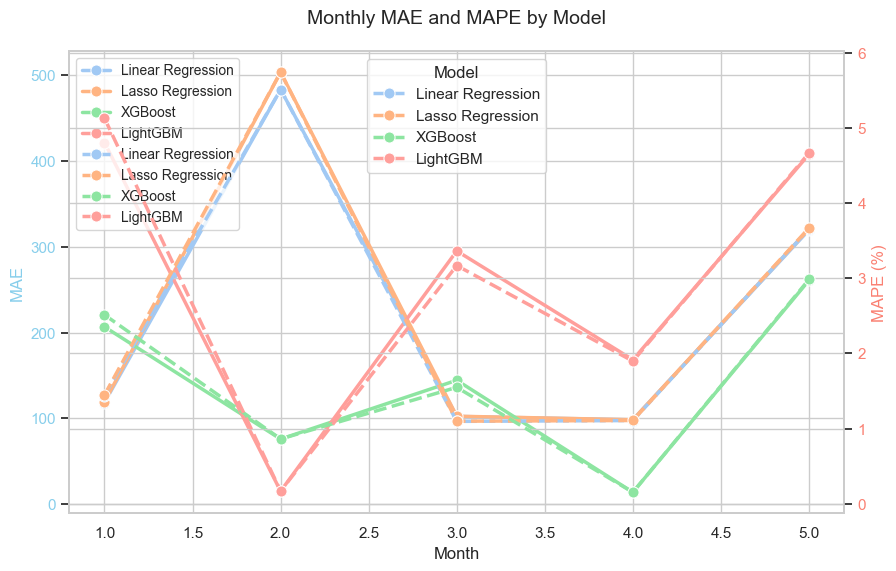

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 monthly_metrics_df 是已经计算好的 DataFrame
# monthly_metrics_df 包含以下列：month, y_test, y_pred, MAE, MAPE, Model

# 设置 seaborn 风格
# sns.set_theme(style="whitegrid", palette="pastel")

# 创建图形和主坐标轴
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制 MAE 折线图（主坐标轴）
sns.lineplot(data=monthly_metrics_df, x="month", y="MAE", hue="Model", marker="o", ax=ax1, linewidth=2.5, markersize=8)

# 设置主坐标轴标签
ax1.set_xlabel("Month", fontsize=12)
ax1.set_ylabel("MAE", color="skyblue", fontsize=12)
ax1.tick_params(axis="y", labelcolor="skyblue")

# 创建副坐标轴
ax2 = ax1.twinx()

# 绘制 MAPE 折线图（副坐标轴）
sns.lineplot(data=monthly_metrics_df, x="month", y="MAPE", hue="Model", marker="o", ax=ax2, linewidth=2.5, markersize=8, linestyle="--")

# 设置副坐标轴标签
ax2.set_ylabel("MAPE (%)", color="salmon", fontsize=12)
ax2.tick_params(axis="y", labelcolor="salmon")

# 设置标题
plt.title("Monthly MAE and MAPE by Model", fontsize=14, pad=20)

# 显示图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", fontsize=10)

# 显示图形
plt.show()

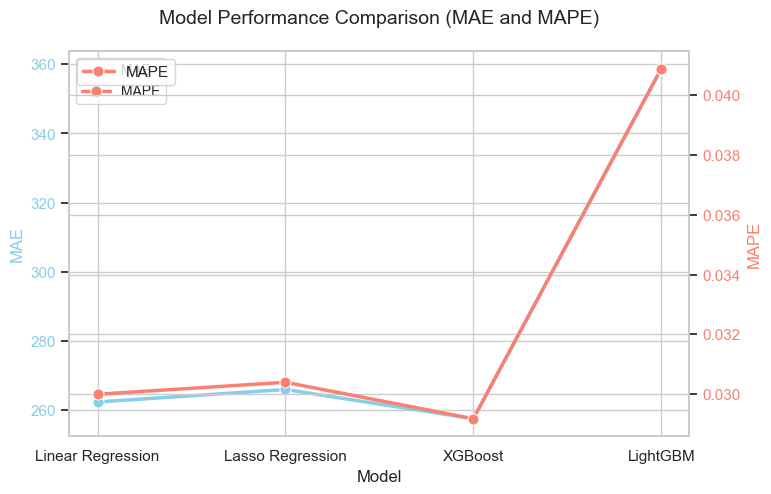

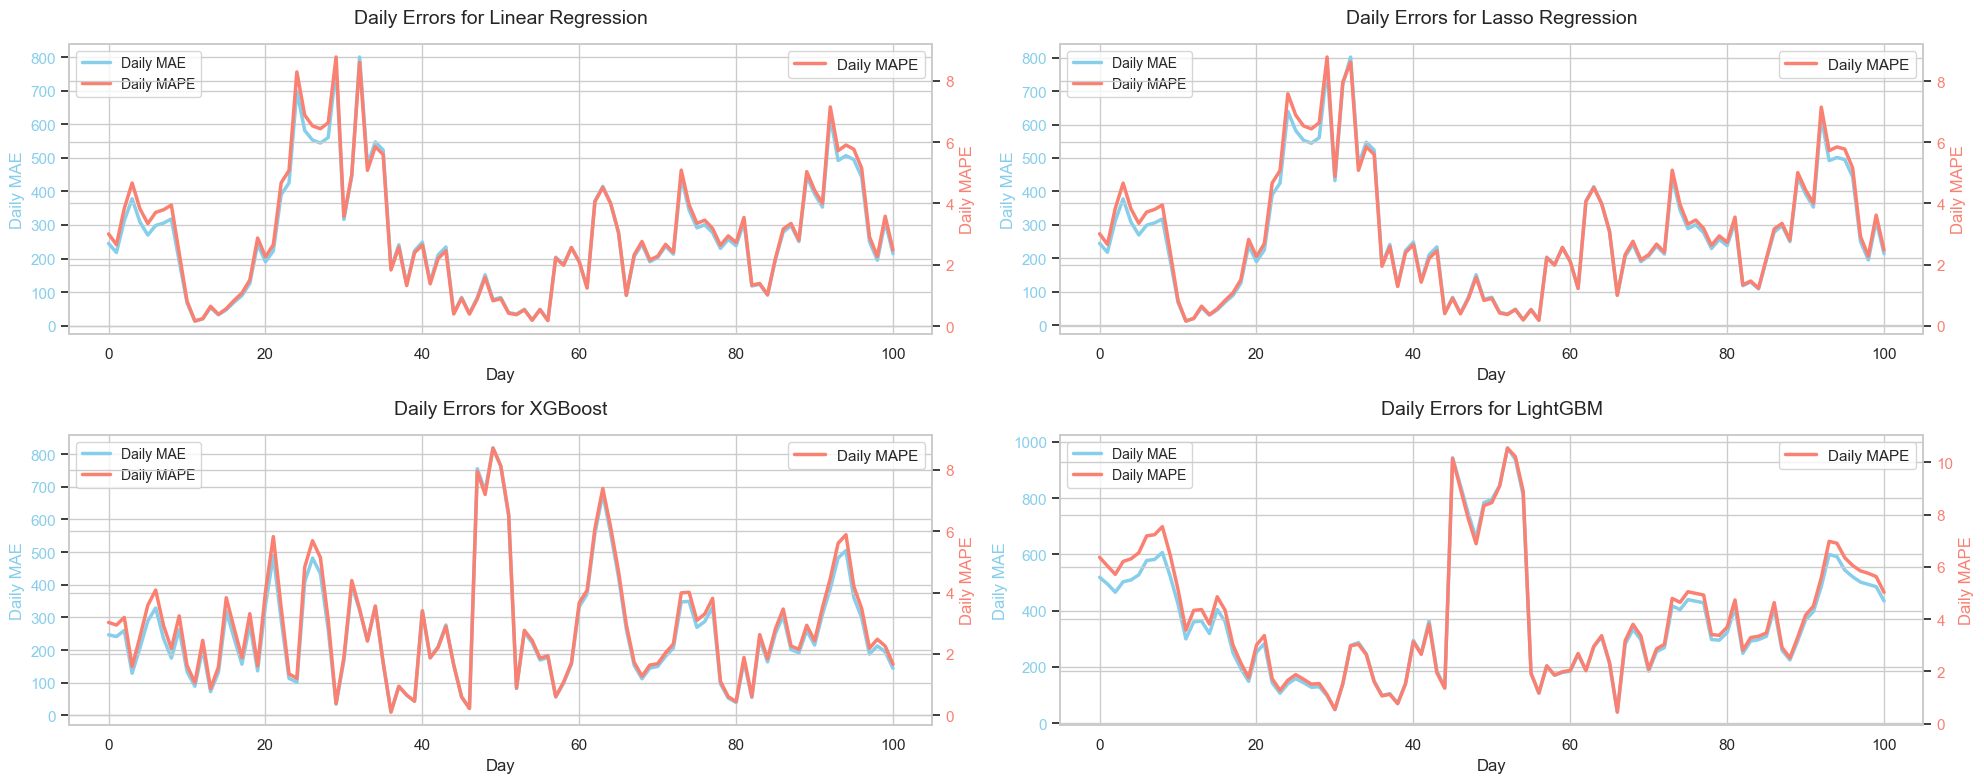

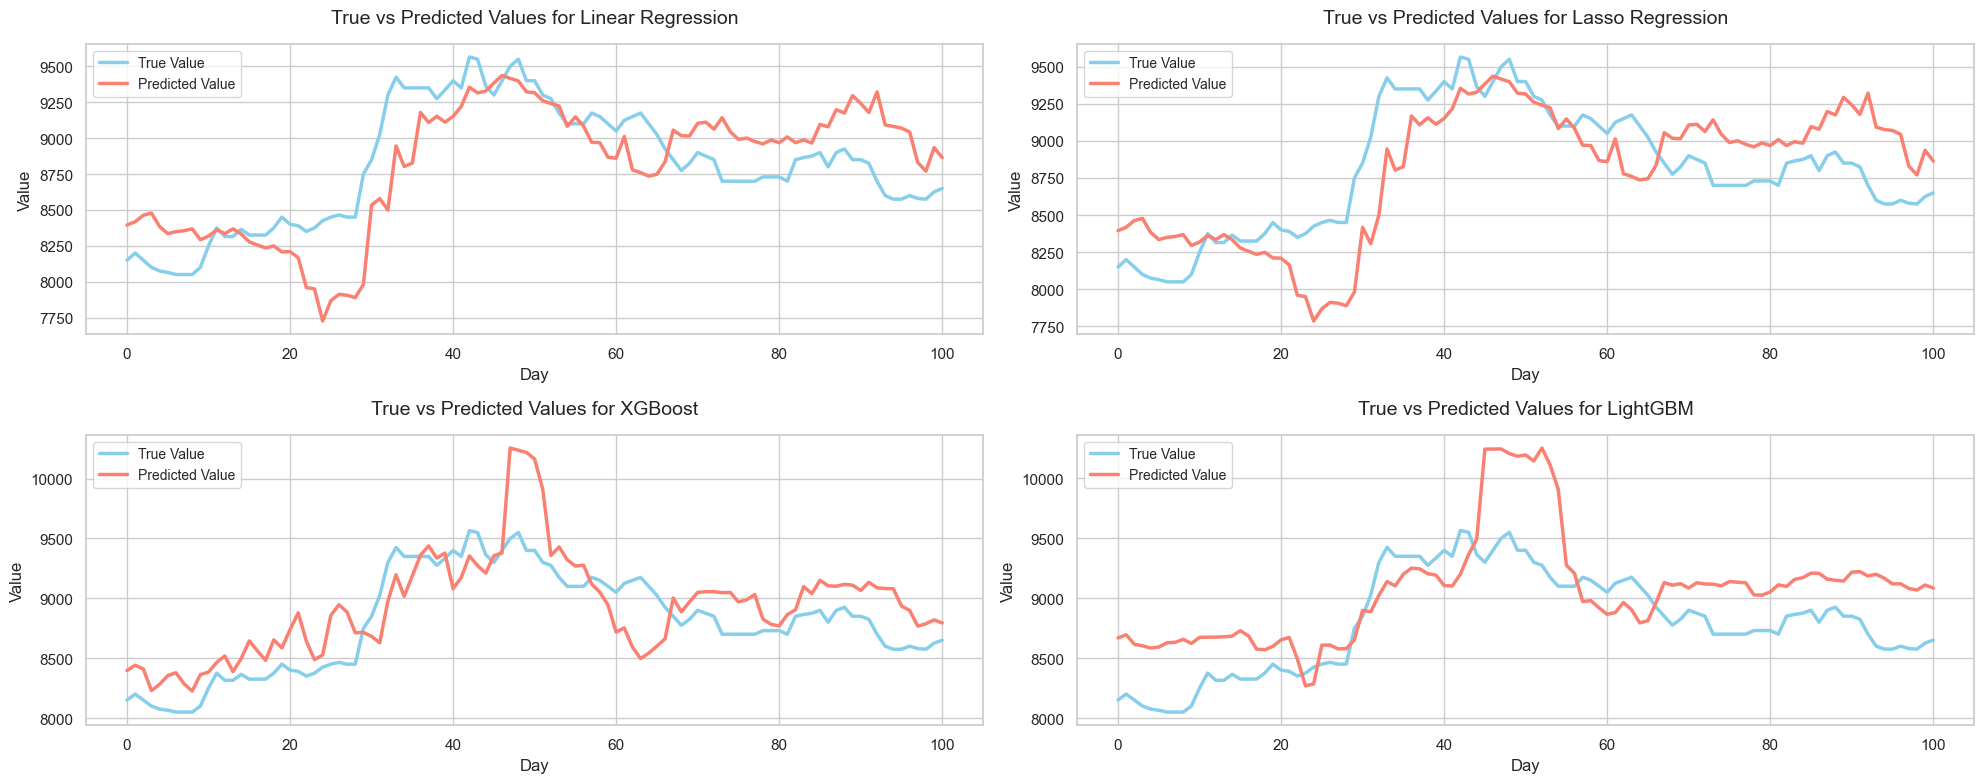

In [105]:
# 2. 使用副坐标轴绘制折线图
plt.figure(figsize=(8, 5))

# 创建主坐标轴
ax1 = plt.gca()

# 绘制 MAE（主坐标轴）
sns.lineplot(data=results_df, x="Model", y="MAE", marker="o", label="MAE", ax=ax1, color="skyblue", linewidth=2.5, markersize=8)

# 设置主坐标轴标签
ax1.set_xlabel("Model", fontsize=12)
ax1.set_ylabel("MAE", color="skyblue", fontsize=12)
ax1.tick_params(axis="y", labelcolor="skyblue")

# 创建副坐标轴
ax2 = ax1.twinx()

# 绘制 MAPE（副坐标轴）
sns.lineplot(data=results_df, x="Model", y="MAPE", marker="o", label="MAPE", ax=ax2, color="salmon", linewidth=2.5, markersize=8)

# 设置副坐标轴标签
ax2.set_ylabel("MAPE", color="salmon", fontsize=12)
ax2.tick_params(axis="y", labelcolor="salmon")

# 设置标题
plt.title("Model Performance Comparison (MAE and MAPE)", fontsize=14, pad=20)

# 显示图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", fontsize=10)

# 显示图形
plt.show()

# 3. 绘制每个模型的每日误差折线图和预测值与真实值的折线比较图
fig1, axes1 = plt.subplots(2, 2, figsize=(20, 8))
fig2, axes2 = plt.subplots(2, 2, figsize=(20, 8))

# 将 axes1 和 axes2 展平为一维数组
axes1 = axes1.flatten()
axes2 = axes2.flatten()

# 遍历每个模型
for idx, (model_name, errors) in enumerate(daily_errors.items()):
    # 绘制每日误差折线图
    ax1 = axes1[idx]
    
    # 绘制每日 MAE
    sns.lineplot(x=np.arange(len(errors["Daily MAE"])), y=errors["Daily MAE"], label="Daily MAE", ax=ax1, color="skyblue", linewidth=2.5)
    
    # 设置主坐标轴标签
    ax1.set_xlabel("Day", fontsize=12)
    ax1.set_ylabel("Daily MAE", color="skyblue", fontsize=12)
    ax1.tick_params(axis="y", labelcolor="skyblue")
    
    # 创建副坐标轴
    ax2 = ax1.twinx()
    
    # 绘制每日 MAPE
    sns.lineplot(x=np.arange(len(errors["Daily MAPE"])), y=errors["Daily MAPE"], label="Daily MAPE", ax=ax2, color="salmon", linewidth=2.5)
    
    # 设置副坐标轴标签
    ax2.set_ylabel("Daily MAPE", color="salmon", fontsize=12)
    ax2.tick_params(axis="y", labelcolor="salmon")
    
    # 设置标题
    ax1.set_title(f"Daily Errors for {model_name}", fontsize=14, pad=15)
    
    # 显示图例
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", fontsize=10)

# 遍历每个模型
for idx, (model_name, predictions) in enumerate(daily_predictions.items()):
    # 绘制预测值与真实值的折线比较图
    ax = axes2[idx]
    
    # 绘制真实值
    sns.lineplot(x=np.arange(len(predictions["y_test"])), y=predictions["y_test"], label="True Value", ax=ax, color="skyblue", linewidth=2.5)
    
    # 绘制预测值
    sns.lineplot(x=np.arange(len(predictions["y_pred"])), y=predictions["y_pred"], label="Predicted Value", ax=ax, color="salmon", linewidth=2.5)
    
    # 设置标题和标签
    ax.set_title(f"True vs Predicted Values for {model_name}", fontsize=14, pad=15)
    ax.set_xlabel("Day", fontsize=12)
    ax.set_ylabel("Value", fontsize=12)
    
    # 显示图例
    ax.legend(loc="upper left", fontsize=10)

# 调整布局
fig1.tight_layout()
fig2.tight_layout()

# 显示图形
plt.show()

In [106]:
import pandas as pd


# 计算月度平均值
monthly_avg = df_cleaned['平均'].resample('M').mean()

# 计算每个月的相对变化（百分比）
monthly_pct_change = monthly_avg.pct_change() * 100
monthly_avg[-7:]

C:\Users\simonpan\AppData\Local\Temp\ipykernel_16608\65951847.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df_cleaned['平均'].resample('M').mean()


日期
2020-11-30    8605.238095
2020-12-31    8524.565217
2021-01-31    8220.500000
2021-02-28    8773.823529
2021-03-31    9313.695652
2021-04-30    8864.318182
2021-05-31    8743.157895
Freq: ME, Name: 平均, dtype: float64

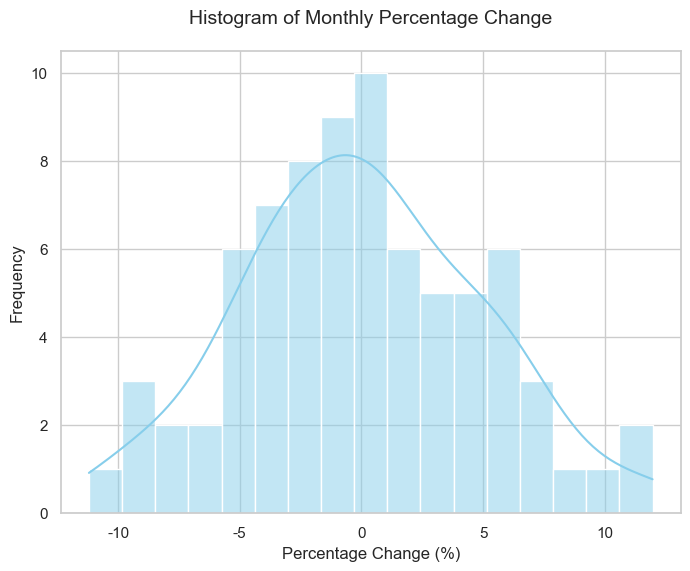

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 monthly_pct_change 是一个已经存在的 Series，表示每个月的相对变化百分比
# monthly_pct_change 是从 2014-12-01 开始的月度相对变化

# 设置 seaborn 风格
sns.set_theme(style="whitegrid")

# 创建图形
plt.figure(figsize=(8, 6))

# 绘制直方图
sns.histplot(monthly_pct_change.dropna(), kde=True, color="skyblue", bins=17)

# 设置标题和标签
plt.title("Histogram of Monthly Percentage Change", fontsize=14, pad=20)
plt.xlabel("Percentage Change (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# 显示图形
plt.show()

In [108]:
import pandas as pd


monthly_pred_means = []

# 遍历每个模型
for model_name, predictions in daily_predictions.items():
    y_pred = predictions['y_pred']
    y_test = predictions['y_test']
    # 将 y_pred 转换为 DataFrame，方便按月份分组
    df = pd.DataFrame({
        'y_test':y_test,
        'y_pred': y_pred,
        'date': y_test.index  # 假设 y_pred 的 index 是日期
    })
    
    # 按月份分组并计算每个月的 y_pred 均值
    monthly_means = df.resample('M', on='date').mean().reset_index()
    
    additional_row = pd.DataFrame({
    'date': [pd.to_datetime('2020-12-31')],
    'y_pred': [8524.565217],
})
    monthly_means = pd.concat([monthly_means, additional_row])
    # 添加模型名称
    monthly_means['Model'] = model_name
    
    # 将结果添加到列表中
    monthly_pred_means.append(monthly_means)

# 合并所有模型的结果
monthly_pred_means_df = pd.concat(monthly_pred_means, ignore_index=True)
monthly_pred_means_df = monthly_pred_means_df.sort_values(by=['Model','date']).fillna(8524.565217)

monthly_pred_means_df

C:\Users\simonpan\AppData\Local\Temp\ipykernel_16608\2866619642.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_means = df.resample('M', on='date').mean().reset_index()
C:\Users\simonpan\AppData\Local\Temp\ipykernel_16608\2866619642.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_means = df.resample('M', on='date').mean().reset_index()
C:\Users\simonpan\AppData\Local\Temp\ipykernel_16608\2866619642.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_means = df.resample('M', on='date').mean().reset_index()
C:\Users\simonpan\AppData\Local\Temp\ipykernel_16608\2866619642.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_means = df.resample('M', on='date').mean().reset_index()


,date,y_test,y_pred,Model
11,2020-12-31,8524.565217,8524.565217,Lasso Regression
6,2021-01-31,8220.500000,8339.480496,Lasso Regression
7,2021-02-28,8773.823529,8270.180718,Lasso Regression
8,2021-03-31,9313.695652,9211.330364,Lasso Regression
9,2021-04-30,8864.318182,8962.589784,Lasso Regression
10,2021-05-31,8743.157895,9063.998854,Lasso Regression
23,2020-12-31,8524.565217,8524.565217,LightGBM
18,2021-01-31,8220.500000,8642.105198,LightGBM
19,2021-02-28,8773.823529,8758.914910,LightGBM
20,2021-03-31,9313.695652,9608.882589,LightGBM


In [109]:
import pandas as pd

# 假设 df 是一个已经存在的 DataFrame，包含以下列：date, y_test, y_pred, Model
# df 是从 2020-12-31 开始的月度数据

# 将 date 列转换为 datetime 类型
df = monthly_pred_means_df
df['date'] = pd.to_datetime(df['date'])

# 按模型分组并计算每个模型的真实值和预测值每个月的涨跌情况
def calculate_monthly_pct_change(group):
    group = group.sort_values('date')  # 按日期排序
    group['y_test_pct_change'] = group['y_test'].pct_change() * 100  # 计算真实值的涨跌
    group['y_pred_pct_change'] = group['y_pred'].pct_change() * 100  # 计算预测值的涨跌
    return group

# 应用函数到每个模型
df_with_pct_change = df.groupby('Model').apply(calculate_monthly_pct_change).reset_index(drop=True).dropna()
df_with_pct_change

C:\Users\simonpan\AppData\Local\Temp\ipykernel_16608\2529752887.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_with_pct_change = df.groupby('Model').apply(calculate_monthly_pct_change).reset_index(drop=True).dropna()


,date,y_test,y_pred,Model,y_test_pct_change,y_pred_pct_change
1,2021-01-31,8220.500000,8339.480496,Lasso Regression,-3.566929,-2.171193
2,2021-02-28,8773.823529,8270.180718,Lasso Regression,6.731020,-0.830984
3,2021-03-31,9313.695652,9211.330364,Lasso Regression,6.153214,11.380037
4,2021-04-30,8864.318182,8962.589784,Lasso Regression,-4.824910,-2.700376
5,2021-05-31,8743.157895,9063.998854,Lasso Regression,-1.366831,1.131471
7,2021-01-31,8220.500000,8642.105198,LightGBM,-3.566929,1.378838
8,2021-02-28,8773.823529,8758.914910,LightGBM,6.731020,1.351635
9,2021-03-31,9313.695652,9608.882589,LightGBM,6.153214,9.704029
10,2021-04-30,8864.318182,9032.554581,LightGBM,-4.824910,-5.997867
11,2021-05-31,8743.157895,9151.120543,LightGBM,-1.366831,1.312651


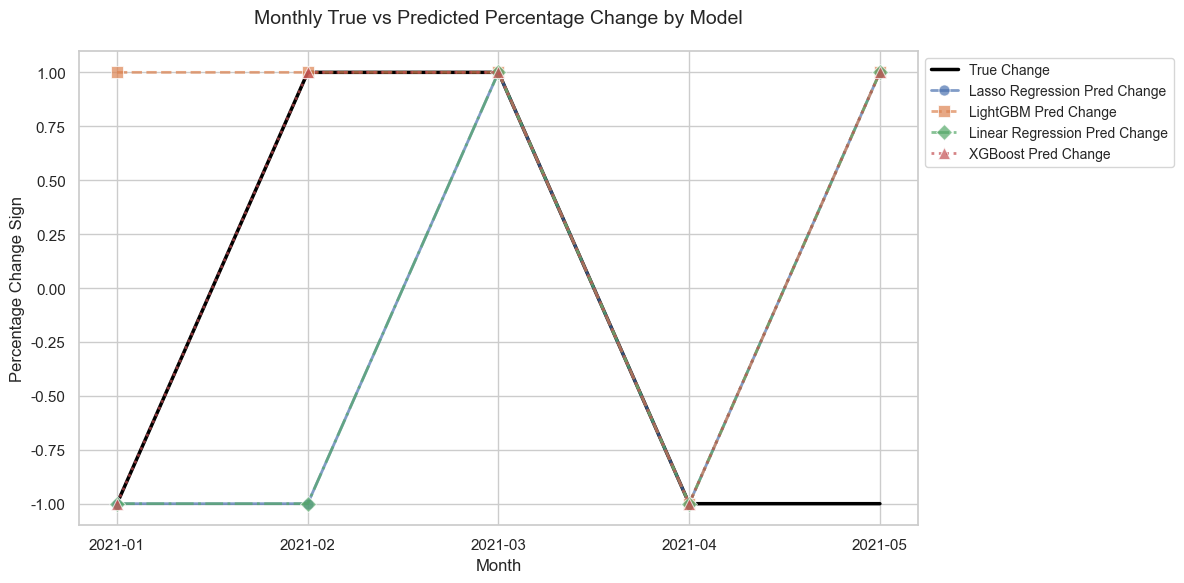

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 假设 df_with_pct_change 是一个已经存在的 DataFrame
# df_with_pct_change 包含以下列：date, y_test_pct_change, y_pred_pct_change, Model

# 将涨跌情况转换为符号
df_with_pct_change_sign = df_with_pct_change.copy()
df_with_pct_change_sign['y_test_pct_change'] = np.sign(df_with_pct_change['y_test_pct_change'])
df_with_pct_change_sign['y_pred_pct_change'] = np.sign(df_with_pct_change['y_pred_pct_change'])

# 提取月份信息
df_with_pct_change_sign['month'] = df_with_pct_change_sign['date'].dt.strftime('%Y-%m')

# 设置 seaborn 风格
sns.set_theme(style="whitegrid")

# 创建图形
plt.figure(figsize=(12, 6))

# 绘制真实涨跌的折线图（所有模型共享一条线）
sns.lineplot(data=df_with_pct_change_sign, x='month', y='y_test_pct_change', label='True Change', color='black', linewidth=2.5)

# 绘制每个模型的预测涨跌折线图
models = df_with_pct_change['Model'].unique()
line_styles = ['-', '--', '-.', ':']  # 不同的线型
markers = ['o', 's', 'D', '^']  # 不同的标记

for i, model in enumerate(models):
    model_data = df_with_pct_change_sign[df_with_pct_change_sign['Model'] == model]
    sns.lineplot(
        data=model_data, 
        x='month', 
        y='y_pred_pct_change', 
        label=f'{model} Pred Change', 
        linestyle=line_styles[i % len(line_styles)],  # 使用不同的线型
        marker=markers[i % len(markers)],  # 使用不同的标记
        markersize=8,  # 标记大小
        alpha=0.7,  # 调整透明度
        linewidth=2
    )

# 设置标题和标签
plt.title("Monthly True vs Predicted Percentage Change by Model", fontsize=14, pad=20)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Percentage Change Sign", fontsize=12)

# 显示图例
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)  # 将图例放置在图形外部

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

In [111]:
import pandas as pd
import numpy as np

# 假设 df_with_pct_change 是一个已经存在的 DataFrame
# df_with_pct_change 包含以下列：date, y_test_pct_change, y_pred_pct_change, Model

# 将涨跌情况转换为符号
df_with_pct_change_sign = df_with_pct_change.copy()
df_with_pct_change_sign['y_test_sign'] = np.sign(df_with_pct_change['y_test_pct_change'])
df_with_pct_change_sign['y_pred_sign'] = np.sign(df_with_pct_change['y_pred_pct_change'])

# 计算符号相同的数量
def count_matching_signs(group):
    return (group['y_test_sign'] == group['y_pred_sign']).sum()

# 按模型分组并计算符号相同的数量
matching_sign_counts = df_with_pct_change_sign.groupby('Model').apply(count_matching_signs).reset_index(name='Matching_Sign_Count')

# 输出结果
matching_sign_counts

C:\Users\simonpan\AppData\Local\Temp\ipykernel_16608\798836275.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  matching_sign_counts = df_with_pct_change_sign.groupby('Model').apply(count_matching_signs).reset_index(name='Matching_Sign_Count')


,Model,Matching_Sign_Count
0,Lasso Regression,3
1,LightGBM,3
2,Linear Regression,3
3,XGBoost,4


# 绘制level级别图

In [119]:
df_with_pct_change

import pandas as pd

# 假设 df_with_pct_change 是一个已经存在的 DataFrame
# df_with_pct_change 包含以下列：date, y_test_pct_change, y_pred_pct_change, Model

# 定义映射函数
def map_values(x):
    if x < -5:
        return -2
    elif -5 <= x < -1:
        return -1
    elif -1 <= x <= 1:
        return 0
    elif 1 < x <= 5:
        return 1
    else:
        return 2
df_with_pct_change.loc[22,'y_pred_pct_change'] = -4.82
# 对 y_test_pct_change 和 y_pred_pct_change 列进行映射
df_with_pct_change['y_test_level'] = df_with_pct_change['y_test_pct_change'].apply(map_values)
df_with_pct_change['y_pred_level'] = df_with_pct_change['y_pred_pct_change'].apply(map_values)

# 输出结果
df_with_pct_change

,date,y_test,y_pred,Model,y_test_pct_change,y_pred_pct_change,y_test_level,y_pred_level
1,2021-01-31,8220.500000,8339.480496,Lasso Regression,-3.566929,-2.171193,-1,-1
2,2021-02-28,8773.823529,8270.180718,Lasso Regression,6.731020,-0.830984,2,0
3,2021-03-31,9313.695652,9211.330364,Lasso Regression,6.153214,11.380037,2,2
4,2021-04-30,8864.318182,8962.589784,Lasso Regression,-4.824910,-2.700376,-1,-1
5,2021-05-31,8743.157895,9063.998854,Lasso Regression,-1.366831,1.131471,-1,1
7,2021-01-31,8220.500000,8642.105198,LightGBM,-3.566929,1.378838,-1,1
8,2021-02-28,8773.823529,8758.914910,LightGBM,6.731020,1.351635,2,1
9,2021-03-31,9313.695652,9608.882589,LightGBM,6.153214,9.704029,2,2
10,2021-04-30,8864.318182,9032.554581,LightGBM,-4.824910,-5.997867,-1,-2
11,2021-05-31,8743.157895,9151.120543,LightGBM,-1.366831,1.312651,-1,1


,date,y_test,y_pred,Model,y_test_pct_change,y_pred_pct_change
1,2021-01-31,8220.500000,8339.480496,Lasso Regression,-3.566929,-2.171193
2,2021-02-28,8773.823529,8270.180718,Lasso Regression,6.731020,-0.830984
3,2021-03-31,9313.695652,9211.330364,Lasso Regression,6.153214,11.380037
4,2021-04-30,8864.318182,8962.589784,Lasso Regression,-4.824910,-2.700376
5,2021-05-31,8743.157895,9063.998854,Lasso Regression,-1.366831,1.131471
7,2021-01-31,8220.500000,8642.105198,LightGBM,-3.566929,1.378838
8,2021-02-28,8773.823529,8758.914910,LightGBM,6.731020,1.351635
9,2021-03-31,9313.695652,9608.882589,LightGBM,6.153214,9.704029
10,2021-04-30,8864.318182,9032.554581,LightGBM,-4.824910,-5.997867
11,2021-05-31,8743.157895,9151.120543,LightGBM,-1.366831,1.312651


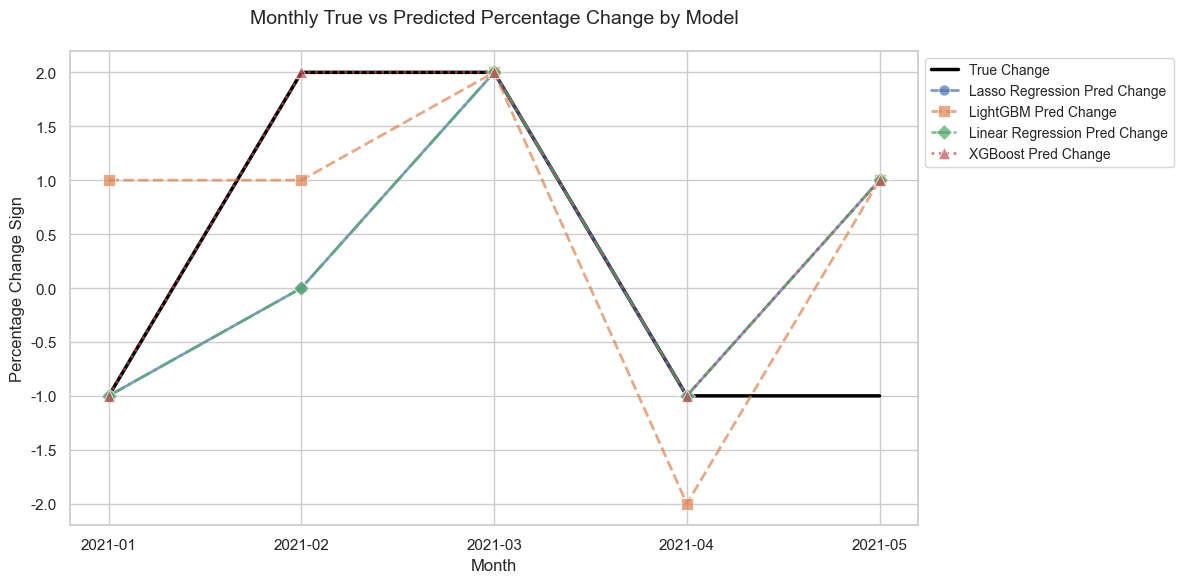

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 假设 df_with_pct_change 是一个已经存在的 DataFrame
# df_with_pct_change 包含以下列：date, y_test_pct_change, y_pred_pct_change, Model


# 提取月份信息
df_with_pct_change['month'] = df_with_pct_change['date'].dt.strftime('%Y-%m')

# 设置 seaborn 风格
sns.set_theme(style="whitegrid")

# 创建图形
plt.figure(figsize=(12, 6))

# 绘制真实涨跌的折线图（所有模型共享一条线）
sns.lineplot(data=df_with_pct_change, x='month', y='y_test_level', label='True Change', color='black', linewidth=2.5)

# 绘制每个模型的预测涨跌折线图
models = df_with_pct_change['Model'].unique()
line_styles = ['-', '--', '-.', ':']  # 不同的线型
markers = ['o', 's', 'D', '^']  # 不同的标记

for i, model in enumerate(models):
    model_data = df_with_pct_change[df_with_pct_change['Model'] == model]
    sns.lineplot(
        data=model_data, 
        x='month', 
        y='y_pred_level', 
        label=f'{model} Pred Change', 
        linestyle=line_styles[i % len(line_styles)],  # 使用不同的线型
        marker=markers[i % len(markers)],  # 使用不同的标记
        markersize=8,  # 标记大小
        alpha=0.7,  # 调整透明度
        linewidth=2
    )

# 设置标题和标签
plt.title("Monthly True vs Predicted Percentage Change by Model", fontsize=14, pad=20)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Percentage Change Sign", fontsize=12)

# 显示图例
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)  # 将图例放置在图形外部

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

In [121]:
import pandas as pd
import numpy as np

# 假设 df_with_pct_change 是一个已经存在的 DataFrame
# df_with_pct_change 包含以下列：date, y_test_pct_change, y_pred_pct_change, Model


# 计算符号相同的数量
def count_matching_signs(group):
    return (group['y_test_level'] == group['y_pred_level']).sum()

# 按模型分组并计算符号相同的数量
matching_sign_counts = df_with_pct_change.groupby('Model').apply(count_matching_signs).reset_index(name='Matching_Sign_Count')

# 输出结果
matching_sign_counts

C:\Users\simonpan\AppData\Local\Temp\ipykernel_16608\3381294615.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  matching_sign_counts = df_with_pct_change.groupby('Model').apply(count_matching_signs).reset_index(name='Matching_Sign_Count')


,Model,Matching_Sign_Count
0,Lasso Regression,3
1,LightGBM,1
2,Linear Regression,3
3,XGBoost,4


C:\Users\simonpan\AppData\Local\Temp\ipykernel_16608\1871936430.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df1['变化率'] = df1['滑动平均'].pct_change()


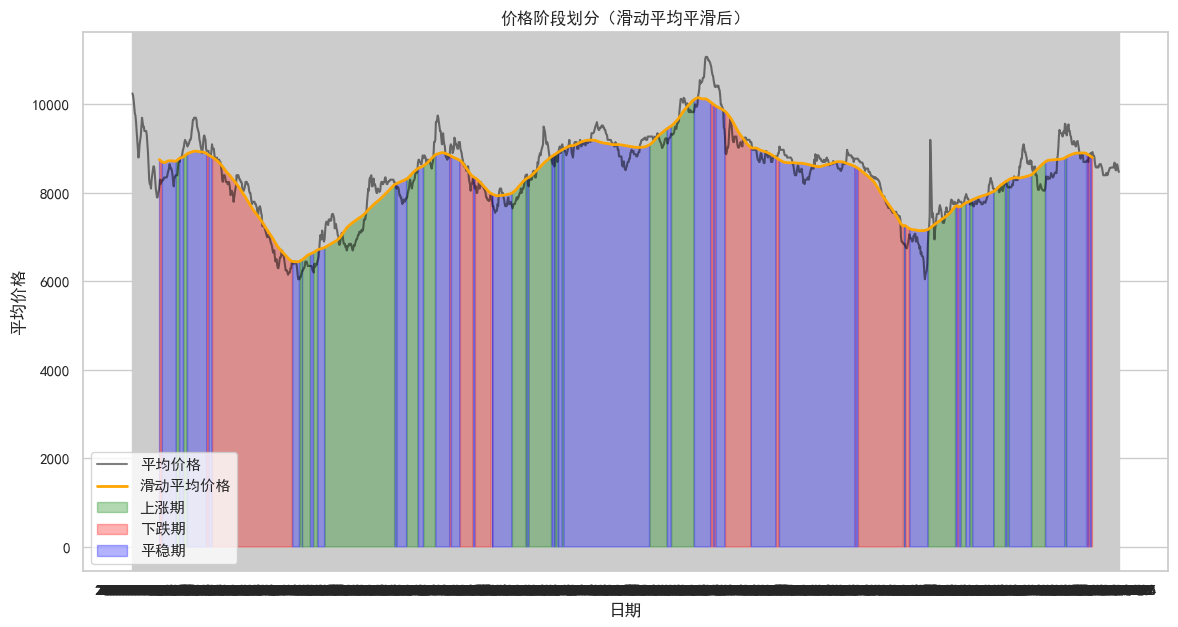

In [127]:
# 计算滑动平均
window_size = 90  # 滑动窗口大小，可以根据实际情况调整
df1['滑动平均'] = df1['平均'].rolling(window=window_size, center=True).mean()

# 计算每日价格变化率
df1['变化率'] = df1['滑动平均'].pct_change()

# 定义阶段划分规则
threshold = 0.001  # 变化率阈值，可以根据实际情况调整
df1['阶段'] = np.where(df1['变化率'] > threshold, '上涨期',
                      np.where(df1['变化率'] < -threshold, '下跌期', '平稳期'))

# 可视化不同阶段
plt.figure(figsize=(14, 7))

# 绘制价格曲线
plt.plot(df1['日期'], df1['平均'], label='平均价格', color='black', alpha=0.5)
plt.plot(df1['日期'], df1['滑动平均'], label='滑动平均价格', color='orange', linewidth=2)

# 根据阶段标记不同颜色
for phase, color in zip(['上涨期', '下跌期', '平稳期'], ['green', 'red', 'blue']):
    plt.fill_between(df1['日期'], df1['滑动平均'], where=(df1['阶段'] == phase), color=color, alpha=0.3, label=phase)

plt.title('价格阶段划分（滑动平均平滑后）')
plt.xlabel('日期')
plt.ylabel('平均价格')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\simonpan\AppData\Local\Temp\ipykernel_16608\602511907.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df1['变化率'] = df1['滑动平均'].pct_change()


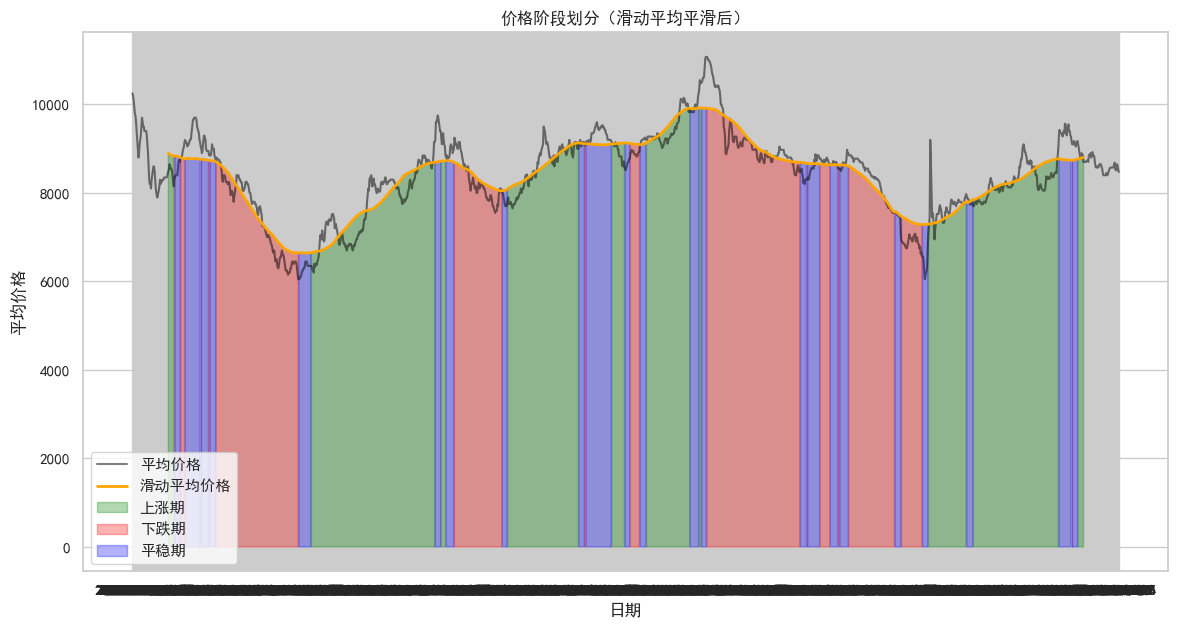

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 假设 df1 是一个包含 '日期' 和 '平均' 列的 DataFrame
# 计算滑动平均
window_size = 120  # 滑动窗口大小，可以根据实际情况调整
df1['滑动平均'] = df1['平均'].rolling(window=window_size, center=True).mean()

# 计算每日价格变化率
df1['变化率'] = df1['滑动平均'].pct_change()

# 定义阶段划分规则
threshold = 0.00002  # 变化率阈值，可以根据实际情况调整
K = 10  # 连续K天上涨或下降

# 判断连续K天上涨或下降
df1['上涨期'] = df1['变化率'].rolling(window=K).apply(lambda x: (x > threshold).all(), raw=True)
df1['下跌期'] = df1['变化率'].rolling(window=K).apply(lambda x: (x < -threshold).all(), raw=True)

# 定义阶段
df1['阶段'] = np.where(df1['上涨期'], '上涨期',
                      np.where(df1['下跌期'], '下跌期', '平稳期'))

# 可视化不同阶段
plt.figure(figsize=(14, 7))

# 绘制价格曲线
plt.plot(df1['日期'], df1['平均'], label='平均价格', color='black', alpha=0.5)
plt.plot(df1['日期'], df1['滑动平均'], label='滑动平均价格', color='orange', linewidth=2)

# 根据阶段标记不同颜色
for phase, color in zip(['上涨期', '下跌期', '平稳期'], ['green', 'red', 'blue']):
    plt.fill_between(df1['日期'], df1['滑动平均'], where=(df1['阶段'] == phase), color=color, alpha=0.3, label=phase)

plt.title('价格阶段划分（滑动平均平滑后）')
plt.xlabel('日期')
plt.ylabel('平均价格')
plt.legend()
plt.grid(True)
plt.show()

In [142]:
df1.drop(columns=['滑动平均','变化率','上涨期','下跌期']).to_csv('阶段.csv', index=None)
df1

,日期,最低,最高,平均,同比,环比,滑动平均,变化率,阶段,上涨期,下跌期
0,2014-12-01,10200.0,10300.0,10250.0,NaN,NaN,NaN,NaN,上涨期,NaN,NaN
1,2014-12-02,10150.0,10250.0,10200.0,NaN,-0.49%,NaN,NaN,上涨期,NaN,NaN
2,2014-12-03,10050.0,10150.0,10100.0,NaN,-0.98%,NaN,NaN,上涨期,NaN,NaN
3,2014-12-04,9900.0,10000.0,9950.0,NaN,-1.49%,NaN,NaN,上涨期,NaN,NaN
4,2014-12-05,9750.0,9850.0,9800.0,NaN,-1.51%,NaN,NaN,上涨期,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1644,2021-07-09,8450.0,8600.0,8525.0,7.57%,0.18%,NaN,0.0,平稳期,0.0,0.0
1645,2021-07-12,8600.0,8700.0,8650.0,9.84%,1.47%,NaN,0.0,平稳期,0.0,0.0
1646,2021-07-13,8520.0,8700.0,8610.0,9.33%,-0.46%,NaN,0.0,平稳期,0.0,0.0
1647,2021-07-14,8450.0,8600.0,8525.0,8.74%,-0.99%,NaN,0.0,平稳期,0.0,0.0
